In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB # https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes
from matplotlib import pyplot as plt

In [2]:
result_l2v = pd.read_csv('/root/Project-CS224N-ED-Disposition/result_l2v_v1.csv')
result_l2v.head()

,doc_key,most_similar_label,highest_similarity_score,Pneumonia,Pneumothorax,Pleural Effusion,Edema,Fracture,Infection,Aspiration,...,Small bowel obstruction,Pancreatitis,Splenic laceration,Liver laceration,Colitis,Pyelonephritis,Nephrolithiasis,Malignancy,Pericaridial effusion,Aortic dissection
0,0,Edema,0.578399,0.372592,0.247433,0.358910,0.578399,0.182795,0.207012,0.343566,...,0.169550,0.192718,0.345765,0.305152,0.204453,0.156657,0.182370,0.183517,0.410827,0.373433
1,1,Intracranial hemorrhage,0.582300,0.237796,0.250413,0.370153,0.345871,0.336697,0.272991,0.176680,...,0.029468,0.160354,0.261489,0.260567,0.125200,-0.059761,0.153361,0.287208,0.293623,0.244099
2,2,Small bowel obstruction,0.474909,0.217554,0.246539,0.264413,0.174407,0.123908,0.196018,0.176534,...,0.474909,0.210745,0.273223,0.359711,0.308034,0.209882,0.241061,0.457533,0.285561,0.312840
3,3,Pleural Effusion,0.621735,0.359045,0.338094,0.621735,0.335418,0.162360,0.304121,0.368442,...,0.158806,0.166371,0.286434,0.240703,0.159598,0.180631,0.127161,0.249665,0.581129,0.400238
4,4,Fracture,0.445201,-0.059400,0.073702,0.176929,0.142462,0.445201,0.055870,0.049981,...,0.078360,0.119567,0.201127,0.227667,0.031279,0.070918,0.087323,0.166940,0.163892,0.306166


In [3]:
result_l2v.shape

(146149, 34)

In [5]:
pneumonia = result_l2v['Pneumonia']
pneumonia

0         0.372592
1         0.237796
2         0.217554
3         0.359045
4        -0.059400
            ...   
146144    0.038144
146145    0.244592
146146    0.082351
146147    0.404529
146148    0.374256
Name: Pneumonia, Length: 146149, dtype: float64

<Axes: >

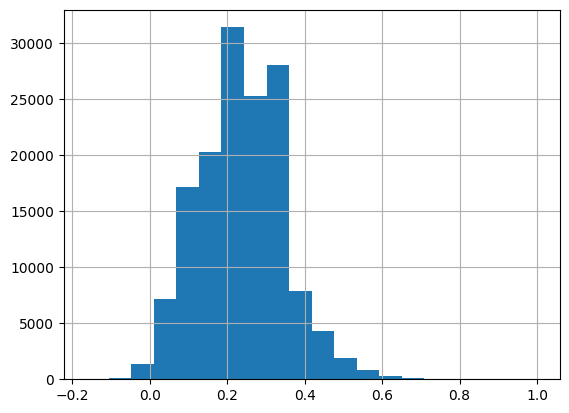

In [6]:
pneumonia.hist(bins=20)

<Axes: >

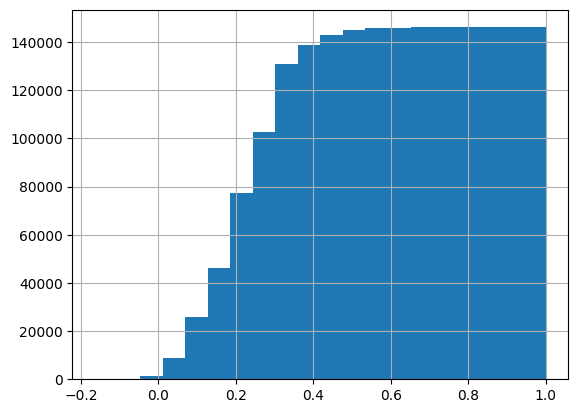

In [7]:
pneumonia.hist(bins=20, cumulative=True)

# Get true percentage of pneumonia reports from chexbert labels

In [4]:
result_chexbert = pd.read_csv('/root/Project-CS224N-ED-Disposition/CheXbert-Labeler/labeled_reports_output.csv')
result_chexbert.head()

,Report Impression,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,1. Interval increase in perihilar opacities a...,NaN,NaN,1.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1. No acute intracranial abnormality. 2. Mil...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,1. Multiple loops of dilated small bowel with...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,1. Interval increased loculated moderate meta...,NaN,NaN,NaN,NaN,NaN,1.0,-1.0,-1.0,NaN,1.0,NaN,NaN,NaN,NaN
4,1. Redemonstrated fracture of the femoral hea...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [9]:
result_chexbert.shape

(146149, 15)

In [10]:
pneu_chex = result_chexbert["Pneumonia"]
pneu_chex

0         NaN
1         NaN
2         NaN
3        -1.0
4         NaN
         ... 
146144    NaN
146145    NaN
146146    NaN
146147   -1.0
146148   -1.0
Name: Pneumonia, Length: 146149, dtype: float64

In [11]:
pneu_chex_counts = pneu_chex.value_counts()
pneu_chex_counts

-1.0    11986
 1.0     4043
 0.0     1968
Name: Pneumonia, dtype: int64

In [12]:
assert pneumonia.shape[0] == pneu_chex.shape[0]
total_reports = pneumonia.shape[0]
true_percent = pneu_chex_counts[1.0] / total_reports
true_percent

0.027663548843987983

# Get top 2.8% of pneumonia cases from lbl2vec scores

In [15]:
total_reports = pneumonia.shape[0]
top_n = round(true_percent * total_reports)
print(total_reports)
print(top_n)
pneumonia.nlargest(top_n)

146149
4043


92391     1.000000
105172    1.000000
75470     0.906517
124618    0.904518
116105    0.830785
            ...   
86274     0.462419
96584     0.462382
63228     0.462290
27160     0.462275
129407    0.462192
Name: Pneumonia, Length: 4043, dtype: float64

In [16]:
# this is the decision boundary: above this value, we label the report as pneumonia=True
threshold = pneumonia.quantile(1-true_percent)
threshold

0.4621828322915653

In [17]:
y_pred = pneumonia >= threshold
y_pred

0         False
1         False
2         False
3         False
4         False
          ...  
146144    False
146145    False
146146    False
146147    False
146148    False
Name: Pneumonia, Length: 146149, dtype: bool

In [18]:
y_pred.value_counts()

False    142106
True       4043
Name: Pneumonia, dtype: int64

In [19]:
y_true = pneu_chex == 1.0
y_true.value_counts()

False    142106
True       4043
Name: Pneumonia, dtype: int64

In [20]:
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.98      0.98    142106
        True       0.42      0.42      0.42      4043

    accuracy                           0.97    146149
   macro avg       0.70      0.70      0.70    146149
weighted avg       0.97      0.97      0.97    146149



In [23]:
ed_keywords = ["Cardiomegaly", "Pneumonia", "Atelectasis", "Pneumothorax", "Pleural Effusion"]
for keyword in ed_keywords:
#     label = f"label_{ed_keywords.index(keyword)}"
    l2v = result_l2v[keyword]
    
    chex = result_chexbert[keyword]
    chex_counts = chex.value_counts()
    total_reports = chex.shape[0]
    true_percent = chex_counts[1.0] / total_reports
    y_true = chex == 1.0
    
    threshold = l2v.quantile(1-true_percent)
    y_pred = l2v >= threshold
    
    print(keyword)
    print(metrics.classification_report(y_true, y_pred))

Cardiomegaly
              precision    recall  f1-score   support

       False       0.98      0.91      0.95    143048
        True       0.08      0.34      0.12      3101

    accuracy                           0.90    146149
   macro avg       0.53      0.63      0.54    146149
weighted avg       0.97      0.90      0.93    146149

Pneumonia
              precision    recall  f1-score   support

       False       0.98      0.98      0.98    142106
        True       0.42      0.42      0.42      4043

    accuracy                           0.97    146149
   macro avg       0.70      0.70      0.70    146149
weighted avg       0.97      0.97      0.97    146149

Atelectasis
              precision    recall  f1-score   support

       False       0.98      0.98      0.98    141417
        True       0.37      0.37      0.37      4732

    accuracy                           0.96    146149
   macro avg       0.67      0.67      0.67    146149
weighted avg       0.96      0.96      

In [24]:
result_chexbert["Pneumonia"]

0         NaN
1         NaN
2         NaN
3        -1.0
4         NaN
         ... 
146144    NaN
146145    NaN
146146    NaN
146147   -1.0
146148   -1.0
Name: Pneumonia, Length: 146149, dtype: float64

# Naive bayes

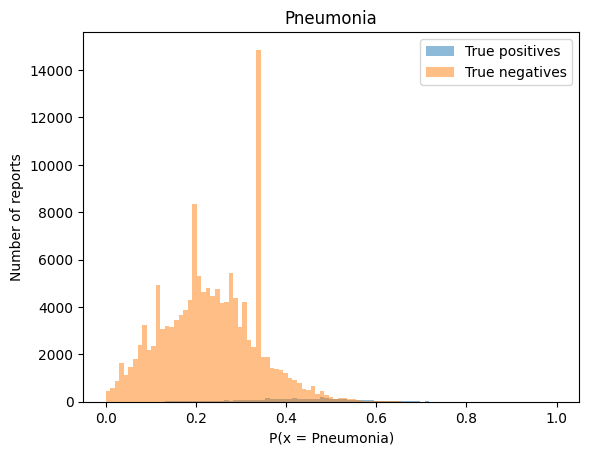

In [5]:
def compare_hist(y_pred, y_true, scale="", title=""):
    assert y_pred.shape == y_true.shape
    df = pd.DataFrame({ 'y_pred': y_pred, 'y_true': y_true })
    
    true_scores = df[df["y_true"] == 1]["y_pred"]
    false_scores = df[df["y_true"] != 1]["y_pred"]
#     print(true)
    bins = np.linspace(0, 1, 100)

    plt.hist(true_scores, bins, alpha=0.5, label='True positives')
    plt.hist(false_scores, bins, alpha=0.5, label='True negatives')
    plt.legend(loc='upper right')
    if scale == 'log':
        plt.yscale('log')
    plt.title(title)
    plt.xlabel(f"P(x = {title})")
    plt.ylabel(f"Number of reports")
    plt.show()

compare_hist(result_l2v["Pneumonia"], result_chexbert["Pneumonia"], scale="", title="Pneumonia")

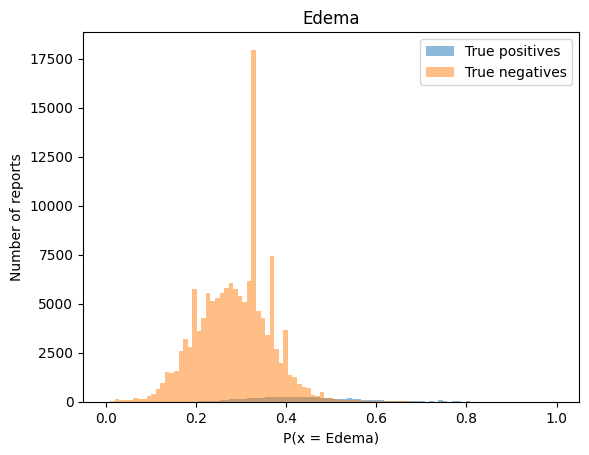

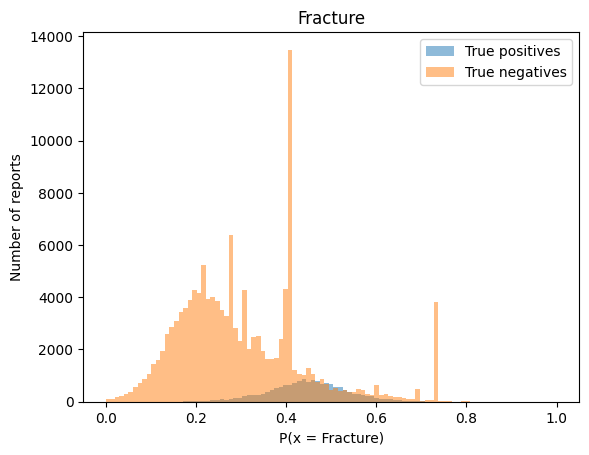

In [6]:
compare_hist(result_l2v["Edema"], result_chexbert["Edema"], title="Edema")
compare_hist(result_l2v["Fracture"], result_chexbert["Fracture"], title="Fracture")

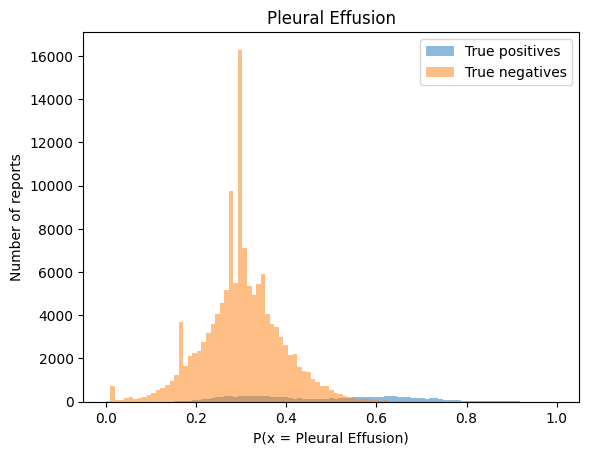

In [9]:
compare_hist(result_l2v["Pleural Effusion"], result_chexbert["Pleural Effusion"], title="Pleural Effusion")

In [38]:
def naive_bayes(l2v_scores, y_true, label):
    X = pd.DataFrame({ 'l2v_scores': l2v_scores })
    y = y_true.mask(y_true != 1, 0)

    nb = GaussianNB()
    nb.fit(X, y)
    y_pred = nb.predict(X)
    print(label)
    print(metrics.classification_report(y, y_pred))
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print("AUC", auc)
    return nb

nb_frac = naive_bayes(result_l2v["Fracture"], result_chexbert["Fracture"], "Fracture")

Fracture
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94    130038
         1.0       0.00      0.00      0.00     16111

    accuracy                           0.89    146149
   macro avg       0.44      0.50      0.47    146149
weighted avg       0.79      0.89      0.84    146149

AUC 0.5


/opt/conda/envs/l2v/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/l2v/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/l2v/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
print(nb_frac.classes_)
print(nb_frac.class_count_)
print(nb_frac.class_prior_)
print(nb_frac.theta_) # mean
print(nb_frac.get_params())

[0. 1.]
[130038.  16111.]
[0.88976319 0.11023681]
[[0.30380844]
 [0.44816069]]
{'priors': None, 'var_smoothing': 1e-09}


In [39]:
ed_keywords = ["Fracture", "Edema", "Cardiomegaly", "Pneumonia", "Atelectasis", "Pneumothorax", "Pleural Effusion"]

nbs = []
for keyword in ed_keywords:
    nb = naive_bayes(result_l2v[keyword], result_chexbert[keyword], keyword)
    nbs.append(nb)

Fracture


/opt/conda/envs/l2v/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/l2v/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/l2v/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94    130038
         1.0       0.00      0.00      0.00     16111

    accuracy                           0.89    146149
   macro avg       0.44      0.50      0.47    146149
weighted avg       0.79      0.89      0.84    146149

AUC 0.5
Edema
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98    139224
         1.0       0.66      0.26      0.38      6925

    accuracy                           0.96    146149
   macro avg       0.81      0.63      0.68    146149
weighted avg       0.95      0.96      0.95    146149

AUC 0.6281333958147803
Cardiomegaly
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    143048
         1.0       0.97      0.17      0.29      3101

    accuracy                           0.98    146149
   macro avg       0.98      0.59      0.64    146149
weighted avg       0.98 

In [ ]:
compare_hist(result_l2v["Pleural Effusion"], result_chexbert["Pleural Effusion"])

TODO: evaluate on test set

In [41]:
"""
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    mauc = auc(fpr, tpr)
"""

3